# Convergence of MaxSum

In [1]:
include("../code/bp_full.jl")
include("../code/optimal_cycle.jl")
using ProgressMeter, StatsBase

In [2]:
p = Progress(10)
for i in 1:10
    k = i
    sleep(1)
    ProgressMeter.next!(p, showvalues=[(:i,i)])
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/crotti/.julia/packages/ProgressMeter/poEzd/src/ProgressMeter.jl:463
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
  i:  10


### 1. Draw random instance and find ground state

In [3]:
# Build a random graph with variables of degree exactly 2
# Inputs: size, rate

include("../code/ldpc_graph.jl")
function cycle_code(n::Int, R::Real; rng=MersenneTwister(0))
    @assert 0≤R≤1
    m = round(Int, n*(1-R))
    nedges, Lambda, Rho = generate_polyn(n,m,degree_type=:nodes)
    nedges = 2n
    H = permutedims(ldpc_matrix(n,m,nedges,Lambda,Rho, accept_multi_edges=false,rng=rng))
end

cycle_code (generic function with 1 method)

In [4]:
# Given a ground state config `x_gs`, the energy of the first excited state:
# Force each variable in turn to take value opposite to what it had in `x_gs`,
#  then find the optimal solution with that variable constraint
# `x0` is the source

function first_excited(H::SparseMatrixCSC, σ_gs::AbstractVector, efield::AbstractVector)
    n = length(σ_gs)
    σ = copy(σ_gs)
    ovl = zeros(n)
    efield_ = copy(efield)
    for i in 1:n
        σ .= +1
        efield_[i] = (-1) * n * σ_gs[i]
        # find optimal solution using the mapping to perfect matching
        _, _, σ = findsol(H, efield_, σ, verbose=false)
        ovl[i] = σ'efield / n
        @assert σ[i] != σ_gs[i]
        # set weight back to default
        efield_[i] = efield[i]
    end
    ovl
end

first_excited (generic function with 1 method)

In [5]:
full2field(h::Vector{NTuple{2,T}}) where {T<:Real} = [hh[1]-hh[2] for hh in h]
decvars(beliefs::Vector{<:Real}) = beliefs .< 0
# zero_msg(n::Int, T::Type) = [(one(T),one(T)) for i in 1:n]
function iteration_saveall!(bp::BPFull; maxiter=10^3, tol=1e-12, damp=0.0, rein=0.0, 
        factor_neigs = [nonzeros(bp.X)[nzrange(bp.X, a)] for a = 1:size(bp.H,1)],
        uu = [zeros(eltype(bp.u[1][1]), nnz(bp.H)) for it in 1:maxiter+1],
        hh = [zeros(eltype(bp.u[1][1]), nnz(bp.H)) for it in 1:maxiter+1],
        beliefs = [zeros(eltype(bp.u[1][1]), size(bp.H,2)) for it in 1:maxiter+1],
        callback=(it, ε, bp)->false)
    
    uu[1] .= full2field(bp.u); hh[1] .= full2field(bp.h); beliefs[1] .= full2field(bp.belief)   
    ε = 0.0
    for it = 1:maxiter
        ε = 0.0
        for a = 1:size(bp.H,1)
            errf = update_factor_ms!(bp, a, factor_neigs[a], damp=damp)
            errf == -1 && return -1,it
            ε = max(ε, errf)
        end
        for i = 1:size(bp.H,2)
            errv = update_var_ms!(bp, i, damp=damp, rein=rein)
            errv == -1 && return -1,it
            ε = max(ε, errv)
        end
        uu[it+1] .= full2field(bp.u); hh[it+1] .= full2field(bp.h); beliefs[it+1] .= full2field(bp.belief)  
        callback(it, ε, bp) && return ε,it
        ε < tol && return ε, it
    end
    ε, maxiter
end

iteration_saveall! (generic function with 1 method)

In [6]:
function single_example_cycle(n::Int, R::Real, rng_idx::Int, noise::Real=0.0)
    rng = MersenneTwister(rng_idx)
    H = cycle_code(n, R; rng=rng)
    s = rand(rng, (-1,1), n)
    efield = s .+ noise*(2*rand(rng,n))
    ovl, _, σ_gs = findsol(H, efield, s, verbose=false)
    Ovl = first_excited(H, σ_gs, efield)
    ε = n*(ovl - maximum(Ovl))
    ε, s, efield, H, σ_gs, rng
end

function single_example_ms(efield, rng::AbstractRNG, H::SparseMatrixCSC, noise::Real=0.0)
    efield_full = [(ef,-ef) for ef in efield]
    ms = BPFull(H, efield_full)
end

single_example_ms (generic function with 2 methods)

In [7]:
function small_examples(n::Int, R::Real, N::Int, noise::Real=0.0; wstar=2, offset=0)
    ε = fill(NaN, N)
    nonmatched = falses(N)
    p = Progress(N)
    for i in 1:N
        ε[i], s, efield, H, σ_gs, rng = single_example_cycle(n, R, i+offset, noise)
        k = ceil(Int, wstar*n^2/ε[i])
        ProgressMeter.next!(p; showvalues = [(:it,i), (:k,k), (:nunmatched,sum(nonmatched))])
        ms = single_example_ms(efield, rng, H)
        err, iters = iteration_ms!(ms, maxiter=k, tol=1e-15)
        x_ms = (argmax.(ms.belief) .== 2)
        x_gs = (σ_gs .< 1)
        x_ms != x_gs && (nonmatched[i] = true)
    end
    ε, nonmatched
end

small_examples (generic function with 2 methods)

## 1. Find a "bad" instance, as small as possible

In [8]:
n = 6
R = 0.5
rng_idx = 2
N = 10^4
noise = 5e-2
offset = 3*10^4
ε, nonmatched = small_examples(n, R, N, noise, offset=offset)
sum(nonmatched)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/crotti/.julia/packages/ProgressMeter/poEzd/src/ProgressMeter.jl:463
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
  it:          100
  k:           5604
  nunmatched:  2


2

In [9]:
ε[nonmatched]

2-element Array{Float64,1}:
 0.0021026790437348453
 0.01607161273609581

In [10]:
rng_idx = findall(nonmatched)[1]
ε, s, efield, H, σ_gs, rng = single_example_cycle(n, R, rng_idx+offset, noise)
x0 = s .== -1
wstar = 2
@show k = ceil(Int, wstar*n^2/ε)
ms = single_example_ms(efield, rng, H);

k = ceil(Int, (wstar * n ^ 2) / ε) = 60875


In [11]:
uu = [zeros(eltype(ms.u[1][1]), nnz(H)) for it in 1:k+1]
hh = copy(uu)
beliefs = [zeros(eltype(ms.u[1][1]), n) for it in 1:k+1]
err, iters = iteration_saveall!(ms, maxiter=k, tol=1e-15, uu=uu, hh=hh, beliefs=beliefs)
x_ms = (argmax.(ms.belief) .== 2)
x_gs = (σ_gs .< 1)
x_ms != x_gs

true

In [12]:
X = decvars.(beliefs)
nunsat = [sum(H*x .% 2) for x in X]
dist = [mean(x .!= x0) for x in X]
decv = [sum(x[i]*2^(i-1) for i in eachindex(x)) for x in X]
p1 = plot(nunsat, label="", ylabel="Nunsat"); xlabel!("iters")
p2 = plot(dist, label="", ylabel="Dist"); xlabel!("iters")
p3 = plot(decv, label="", ylabel="Decision"); xlabel!("iters")
plot(p1,p2,p3, layout=(3,1), size=(950,400), margin=5Plots.mm)

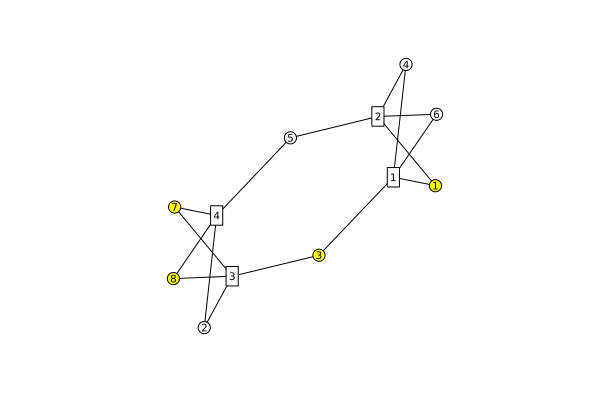

In [19]:
include("../code/plotters/plot_graph.jl")
plot(H, randseed=1, source=x0)

In [147]:
n = 14
R = 0.5
rng_idx = 7
rng = MersenneTwister(rng_idx)
H = cycle_code(n, R; rng=rng)
x0 = bitrand(rng, n)   # source
s = (-1) .^ x0
noise = 1e-2
efield = s .+ randn(rng, n)*noise
d, dist, σ_gs = findsol(H, efield)
x_gs = (σ_gs .== -1)
ovl = σ_gs'efield / n

Iter 1. Overlap 0.7131. Cycle weight -6.0204. Energy shift -6.020396696410123
Iter 2. Overlap 0.7131. Cycle weight 0.0. Energy shift 0.0


0.7130858580464918

### 2. Find the energy shift to the first excited state
(Re-run the code if ground state degenerate)

In [148]:
Ovl = first_excited(H, σ_gs, efield)

14-element Vector{Float64}:
 0.5760587559561282
 0.570121790244052
 0.7120907953690929
 0.4327071466317225
 0.42820740108362576
 0.5760587559561282
 0.569070565691508
 0.7120907953690929
 0.5698658417598595
 0.4327071466317225
 0.5698658417598595
 0.570121790244052
 0.4303634351519278
 0.570121790244052

In [149]:
ovl, maximum(Ovl)

(0.7130858580464918, 0.7120907953690929)

In [150]:
ϵ = ovl - maximum(Ovl)

0.0009950626773989057

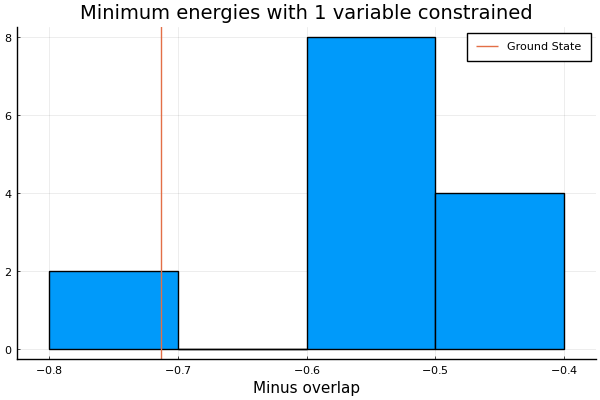

In [157]:
using Plots
histogram(-Ovl, label="")
vline!([-ovl], label="Ground State")
xlabel!("Minus overlap")
title!("Minimum energies with 1 variable constrained")

### 3. Run MaxSum
for $k=\biggl\lceil\frac{nw^*}{\epsilon}\biggr\rceil$ iterations where $w^*=2$ is the maximum reward for flipping a variable

In [30]:
efield_full = [(ef,-ef) for ef in efield]
ms = BPFull(H, efield_full)
wstar = 2
k = ceil(Int, wstar*n/ϵ)

28139

In [18]:
# efield_vanishing = [(efield[i], (0.5,0.5)) for i in eachindex(efield)]
# ms = ms_full_vanishing(H, efield_vanishing) 

In [32]:
global dist = fill(NaN, k)
global nunsat = fill(NaN, k)
global X = fill(NaN, k)

function cb(it, ε, bp)
    mod(it, 10^4)==0 && println("Iter $it.\terr=$ε")
    s = map(t->sign(t[1]-t[2]), bp.efield)
    x = falses(length(s))
    nunsat_, _,dist_ = performance(bp, s, x)
    X[it] = sum(x[i]*2^(i-1) for i in eachindex(x))
#     @show it, size(nunsat)
    nunsat[it] = nunsat_; dist[it] = dist_
    decvars = argmax.(bp.belief) .== 2
#     decvars == x_gs && return true
    undec = sum(s.==0)
    undec>0 && println(undec, " undecided")
    false
end

cb (generic function with 1 method)

In [33]:
err, iters = iteration_ms!(ms, maxiter=k, tol=1e-15, callback=cb)

Iter 10000.	err=1.8837251660177685
Iter 20000.	err=1.8837251660254424


(1.8837251660254424, 28139)

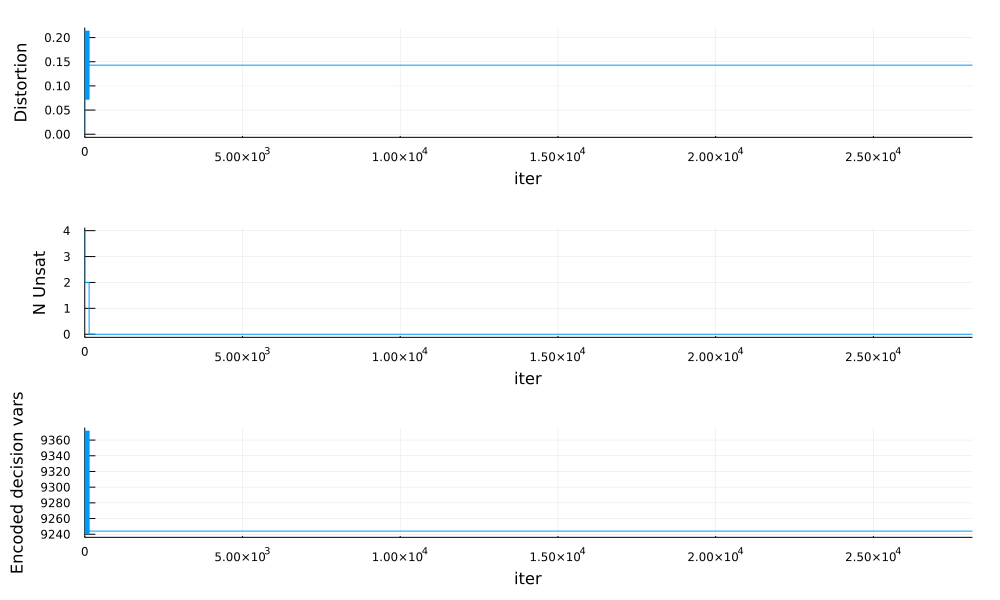

In [34]:
p1 = plot(dist, label="")
xlabel!(p1, "iter")
ylabel!(p1, "Distortion")
xlims!((0,iters))
p2 = plot(nunsat, label="")
xlabel!(p2, "iter")
ylabel!(p2, "N Unsat")
xlims!((0,iters))
p3 = plot(X, label="")
xlabel!(p3, "iter")
ylabel!(p3, "Encoded decision vars")
xlims!((0,iters))
plot(p1,p2,p3,layout=(3,1), size=(1000,600), margin=5Plots.mm)

In [35]:
x_ms = (argmax.(ms.belief) .== 2);
# beliefs = [t[1]-t[2] for t in ms.belief]
# beliefs_hist = sort(proportionmap(beliefs))

In [36]:
a,b,c = performance(ms, s)
println(a, " unsat. Distance of decision vars from source = ", c)

0 unsat. Distance of decision vars from source = 0.14285714285714285


In [37]:
@show x_gs == x_ms
dist[iters], d

x_gs == x_ms = true


(0.14285714285714285, -0.7130858580464918)

In [38]:
i = findfirst(x_gs .!= x_ms)

## 4. Try small examples

In [64]:
n = 14
R = 0.5
N = 500
noise = 1e-2

0.01

In [65]:
ε, nonmatched = small_examples(n, R, N, noise)
sum(nonmatched)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


500

In [53]:
i = nonmatched[6]
ε[i], x0, H, x_gs, rng = single_example_cycle(n, R, i, noise)
k = ceil(Int, wstar*n^2/ε[i])
ms = single_example_ms(x0, rng, H, noise)
global dist = fill(NaN, k)
global nunsat = fill(NaN, k)
global X = fill(NaN, k)
global nchanged_msg = fill(NaN, k)
global nchanged_var = fill(NaN, k)
err, iters = iteration_ms!(ms, maxiter=k, tol=1e-15, callback=cb)
x_ms = (argmax.(ms.belief) .== 2)
@show parity(H, x_ms)
@show sum(x_gs .!= x_ms)
@show mean(x_gs.!=x0), mean(x_ms.!=x0);

LoadError: MethodError: no method matching single_example_cycle(::Int64, ::Float64, ::Bool, ::Float64)
[0mClosest candidates are:
[0m  single_example_cycle(::Int64, ::Real, [91m::Int64[39m, ::Real) at In[41]:1
[0m  single_example_cycle(::Int64, ::Real, [91m::Int64[39m, ::Real, [91m::Any[39m) at In[41]:1
[0m  single_example_cycle(::Int64, ::Real, [91m::Int64[39m) at In[41]:1

In [242]:
k = ceil(Int, wstar*n^2/ε[i])
ε[i], k

(1.0, 392)

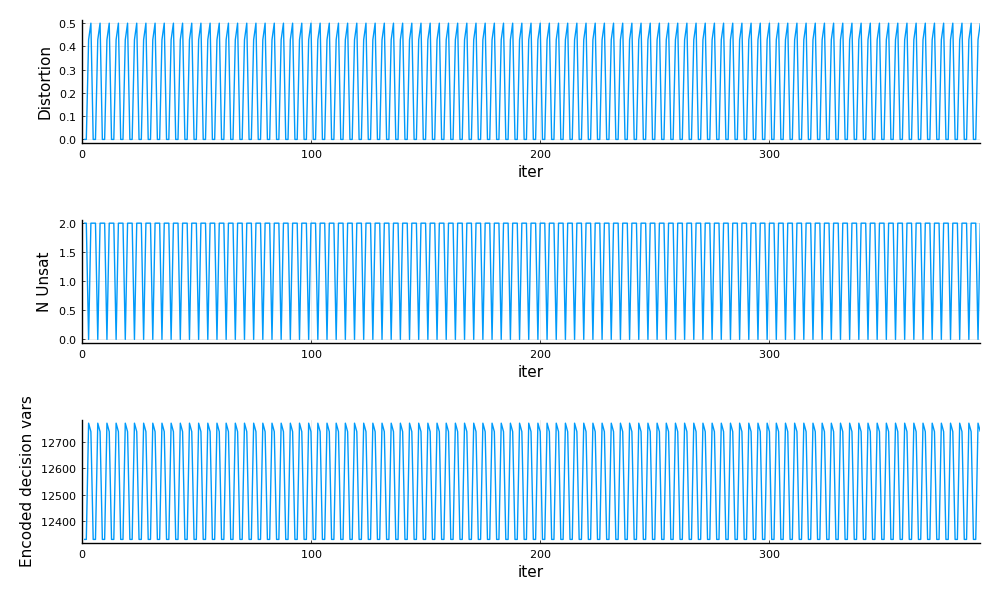

In [243]:
p1 = plot(dist, label="")
xlabel!(p1, "iter")
ylabel!(p1, "Distortion")
xlims!((0,iters))
p2 = plot(nunsat, label="")
xlabel!(p2, "iter")
ylabel!(p2, "N Unsat")
xlims!((0,iters))
p3 = plot(X, label="")
xlabel!(p3, "iter")
ylabel!(p3, "Encoded decision vars")
xlims!((0,iters))
plot(p1,p2,p3,layout=(3,1), size=(1000,600), margin=5Plots.mm)

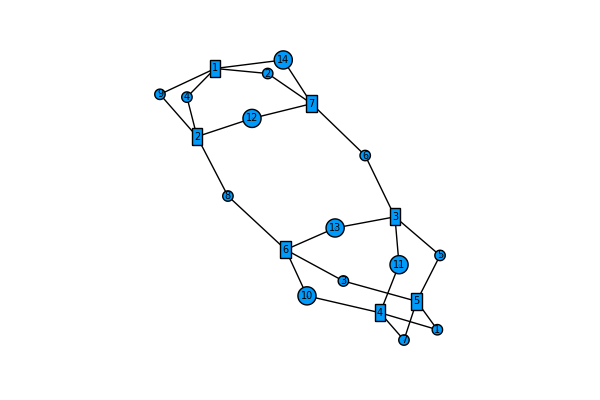

┌ Warning: Indices Base.OneTo(21) of attribute `markershape` does not match data indices 1:1175.
└ @ Plots /home/crotti/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Info: Data contains NaNs or missing values, and indices of `markershape` vector do not match data indices.
│ If you intend elements of `markershape` to apply to individual NaN-separated segements in the data,
│ pass each segment in a separate vector instead, and use a row vector for `markershape`. Legend entries 
│ may be suppressed by passing an empty label.
│ For example,
│     plot([1:2,1:3], [[4,5],[3,4,5]], label=["y" ""], markershape=[1 2])
└ @ Plots /home/crotti/.julia/packages/Plots/SVksJ/src/utils.jl:104


In [244]:
include("../code/plotters/plot_graph.jl")
plot(H, randseed=1)

In [245]:
Array(H)

7×14 Matrix{Bool}:
 0  1  0  1  0  0  0  0  1  0  0  0  0  1
 0  0  0  1  0  0  0  1  1  0  0  1  0  0
 0  0  0  0  1  1  0  0  0  0  1  0  1  0
 1  0  0  0  0  0  1  0  0  1  1  0  0  0
 1  0  1  0  1  0  1  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  1  0  1  0  0  1  0
 0  1  0  0  0  1  0  0  0  0  0  1  0  1

In [66]:
H = sparse([ 0  1  0  1  0  0  0  0  1  0  0  0  0  1;
 0  0  0  1  0  0  0  1  1  0  0  1  0  0;
 0  0  0  0  1  1  0  0  0  0  1  0  1  0;
 1  0  0  0  0  0  1  0  0  1  1  0  0  0;
 1  0  1  0  1  0  1  0  0  0  0  0  0  0;
 0  0  1  0  0  0  0  1  0  1  0  0  1  0;
 0  1  0  0  0  1  0  0  0  0  0  1  0  1;])

7×14 SparseMatrixCSC{Int64, Int64} with 28 stored entries:
 ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  ⋅
 1  ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1  ⋅
 ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1

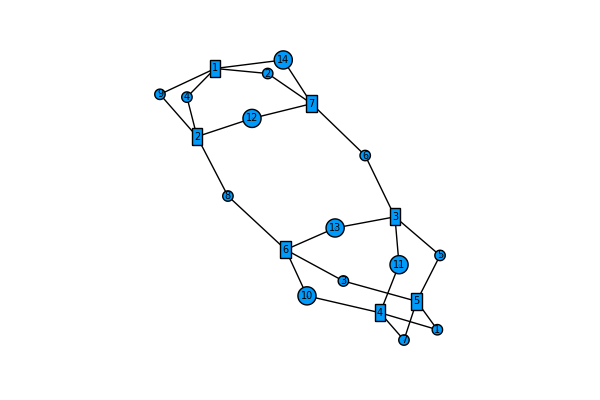

┌ Warning: Indices Base.OneTo(21) of attribute `markershape` does not match data indices 1:1175.
└ @ Plots /home/crotti/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Info: Data contains NaNs or missing values, and indices of `markershape` vector do not match data indices.
│ If you intend elements of `markershape` to apply to individual NaN-separated segements in the data,
│ pass each segment in a separate vector instead, and use a row vector for `markershape`. Legend entries 
│ may be suppressed by passing an empty label.
│ For example,
│     plot([1:2,1:3], [[4,5],[3,4,5]], label=["y" ""], markershape=[1 2])
└ @ Plots /home/crotti/.julia/packages/Plots/SVksJ/src/utils.jl:104


In [68]:
plot(H, randseed=1)

In [81]:
x0 = vec([0 1 0 1 1 0 0 0 0 0 1 0 0 1]);

In [111]:
efield = (-1) .^ x0 .+ 1e-4*randn(n)
ovl, _, σ_gs = findsol(H, efield, verbose=false)

(-0.7142733360818367, [-0.7142682222111151, -0.7142733360818367, -0.7142733360818367, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [-1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1])

In [112]:
x_gs = (σ_gs .== -1)

14-element BitVector:
 1
 1
 0
 1
 1
 0
 0
 0
 1
 0
 1
 0
 0
 1

In [113]:
[x0 x_gs]

14×2 Matrix{Int64}:
 0  1
 1  1
 0  0
 1  1
 1  1
 0  0
 0  0
 0  0
 0  1
 0  0
 1  1
 0  0
 0  0
 1  1

In [114]:
sum(x_gs .!= x0)

2

In [115]:
(H * x_gs) .% 2

7-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0

In [116]:
x_gs

14-element BitVector:
 1
 1
 0
 1
 1
 0
 0
 0
 1
 0
 1
 0
 0
 1

In [117]:
efield_full = [(ef,-ef) for ef in efield]
ms = BPFull(H, efield_full)
iteration_ms!(ms, maxiter=2)
x_ms = argmax.(ms.belief) .== 2
[1:14 x_ms x0]

14×3 Matrix{Int64}:
  1  1  0
  2  1  1
  3  0  0
  4  0  1
  5  1  1
  6  0  0
  7  1  0
  8  0  0
  9  1  0
 10  0  0
 11  1  1
 12  0  0
 13  0  0
 14  1  1

In [118]:
iteration_ms!(ms, maxiter=1)
x_ms2 = argmax.(ms.belief) .== 2
[x_ms x_ms2]

14×2 BitMatrix:
 1  0
 1  1
 0  0
 0  1
 1  1
 0  0
 1  0
 0  0
 1  0
 0  0
 1  1
 0  0
 0  0
 1  1

In [119]:
parity(H, x_ms)

4

In [247]:
idx = [1,7,2,14,4,9]
[x0[idx] x_ms[idx] x_gs[idx]]

6×3 BitMatrix:
 0  1  0
 0  1  0
 0  0  0
 1  1  1
 1  0  1
 0  1  0

In [252]:
x0[[2,14]]

2-element BitVector:
 0
 1

In [123]:
x_gs
x2 = copy(x_gs)
x2[2] = 1; x2[14] = 0;
@show parity(H, x2)
mean(x2 .!= x0), mean(x_gs .!= x0)
ovl = σ_gs'efield / n

parity(H, x2) = 2


0.7142733360818367

In [124]:
Ovl = first_excited(H, σ_gs, efield)

14-element Vector{Float64}:
 0.7142611077925487
 0.5713786147036385
 0.5714342358601436
 0.7142682222111151
 0.5714140589514979
 0.2857528128349262
 0.7142611077925487
 0.2857528128349262
 0.7142682222111151
 0.5714342358601436
 0.5714140589514979
 0.5713786147036385
 0.42860446173833705
 0.5713696194049498

In [125]:
σ = copy(σ_gs)
σ[[1,7]] .*= -1
σ'efield

9.999655509095682

In [127]:
ep = -n*maximum(Ovl)+ n*ovl

7.159419010349666e-5

In [128]:
iteration_ms!(ms, maxiter=n/ep)
x_ms = argmax.(ms.belief) .== 2

14-element BitVector:
 1
 1
 0
 1
 1
 0
 0
 0
 1
 0
 1
 0
 0
 1

In [129]:
[x_gs x_ms]

14×2 BitMatrix:
 1  1
 1  1
 0  0
 1  1
 1  1
 0  0
 0  0
 0  0
 1  1
 0  0
 1  1
 0  0
 0  0
 1  1

In [214]:
ε[i], x0, H, x_gs, rng = single_example_cycle(n, R, i, noise)
ms = single_example_ms(x0, rng, H, noise);

LoadError: BoundsError: attempt to access Tuple{Float64, BitVector, SparseMatrixCSC{Bool, Int64}, BitVector, MersenneTwister} at index [6]